<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Histogram**


Estimated time needed: **45** minutes


In this lab, you will focus on the visualization of data. The dataset will be provided through an RDBMS, and you will need to use SQL queries to extract the required data.


## Objectives


In this lab, you will perform the following:


- Visualize the distribution of data using histograms.

- Visualize relationships between features.

- Explore data composition and comparisons.


## Demo: Working with database


#### Download the database file.


In [1]:
!wget -O survey-data.sqlite https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite

--2026-01-01 19:16:44--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211415040 (202M) [application/octet-stream]
Saving to: ‘survey-data.sqlite’

survey-data.sqlite  100%[===================>] 201.62M  99.3MB/s    in 2.0s    

2026-01-01 19:16:47 (99.3 MB/s) - ‘survey-data.sqlite’ saved [211415040/211415040]



#### Install the required libraries and import them


In [ ]:
#!pip install pandas

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

#### Connect to the SQLite database


In [3]:
conn = sqlite3.connect('survey-data.sqlite')

## Demo: Basic SQL queries

**Demo 1: Count the number of rows in the table**


In [ ]:
QUERY = "SELECT COUNT(*) FROM main"
df = pd.read_sql_query(QUERY, conn)
print(df)


   COUNT(*)
0     65437


**Demo 2: List all tables**


In [ ]:
QUERY = """
SELECT name as Table_Name
FROM sqlite_master
WHERE type = 'table'
"""
pd.read_sql_query(QUERY, conn)


,Table_Name
0,main


**Demo 3: Group data by age**


In [ ]:
QUERY = """
SELECT Age, COUNT(*) as count
FROM main
GROUP BY Age
ORDER BY Age
"""
df_age = pd.read_sql_query(QUERY, conn)
print(df_age)


                  Age  count
0     18-24 years old  14098
1     25-34 years old  23911
2     35-44 years old  14942
3     45-54 years old   6249
4     55-64 years old   2575
5   65 years or older    772
6   Prefer not to say    322
7  Under 18 years old   2568


In [5]:
#One clean pipeline for ALL tasks (run once)

import numpy as np # Import numpy for np.nan

# ---------- Helpers ----------
def to_num(s):
    return pd.to_numeric(s, errors="coerce")

def parse_years_code_pro(x):
    """Convert YearsCodePro to numeric."""
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        t = x.strip().lower()
        if t.startswith("less"):   # "Less than 1 year"
            return 0.5
        if t.startswith("more"):   # "More than 50 years"
            return 51
    return pd.to_numeric(x, errors="coerce")

def cap_at_quantile(series, q=0.99):
    """Cap extreme outliers for readability (keeps distribution shape)."""
    s = series.dropna()
    if len(s) == 0:
        return series, np.nan
    cap = s.quantile(q)
    return np.minimum(series, cap), cap

def summarize(df, cols, name="df"):
    print(f"\n--- {name} ---")
    print("rows:", len(df))
    for c in cols:
        if c in df.columns:
            nonnull = df[c].notna().sum()
            nunique = df[c].nunique(dropna=True)
            print(f"{c}: non-null={nonnull}, unique={nunique}, dtype={df[c].dtype}")
            # show small value_counts for categorical-like columns
            if nunique <= 15:
                print(df[c].value_counts(dropna=True).head(15).sort_index())
        else:
            print(f"{c}: MISSING COLUMN")

# ---------- Load base columns once ----------
df0 = pd.read_sql_query("""
SELECT
  Age,
  CompTotal,
  ConvertedCompYearly,
  DevType,
  Country,
  Employment,
  YearsCodePro,
  JobSatPoints_6
FROM main
""", conn)

# ---------- Standard cleaning ----------
df = df0.copy()

# Numeric money columns
df["CompTotal_num"] = to_num(df["CompTotal"])
df["ConvertedCompYearly_num"] = to_num(df["ConvertedCompYearly"])

# Remove impossible / non-positive compensation (for salary plots)
df.loc[df["CompTotal_num"] <= 0, "CompTotal_num"] = np.nan
df.loc[df["ConvertedCompYearly_num"] <= 0, "ConvertedCompYearly_num"] = np.nan

# YearsCodePro
df["YearsCodePro_num"] = df["YearsCodePro"].apply(parse_years_code_pro)
df.loc[df["YearsCodePro_num"] < 0, "YearsCodePro_num"] = np.nan

# Age: keep the original categories (for Task 2.1), and also make a numeric midpoint (for Task 1.2)
age_s = df["Age"].astype(str)
m = age_s.str.extract(r"(\d+)\s*-\s*(\d+)").astype(float)
df["Age_num"] = m.mean(axis=1)
df.loc[age_s.str.contains("Under", case=False, na=False), "Age_num"] = 16
df.loc[age_s.str.contains("or older", case=False, na=False), "Age_num"] = 70
# Everything else (Prefer not to say, etc.) becomes NaN, which is fine for numeric plots

# JobSatPoints_6
df["JobSatPoints_6_num"] = to_num(df["JobSatPoints_6"])

# DevType: use first role (DevType often contains multiple roles separated by ";")
df["DevType_first"] = df["DevType"].astype(str).str.split(";").str[0].str.strip()

summarize(df, ["CompTotal_num","ConvertedCompYearly_num","YearsCodePro_num","Age","Age_num","JobSatPoints_6_num","DevType_first","Country","Employment"], "CLEANED BASE DF")



--- CLEANED BASE DF ---
rows: 65437
CompTotal_num: non-null=33613, unique=3336, dtype=float64
ConvertedCompYearly_num: non-null=23435, unique=6113, dtype=float64
YearsCodePro_num: non-null=51610, unique=52, dtype=float64
Age: non-null=65437, unique=8, dtype=object
Age
18-24 years old       14098
25-34 years old       23911
35-44 years old       14942
45-54 years old        6249
55-64 years old        2575
65 years or older       772
Prefer not to say       322
Under 18 years old     2568
Name: count, dtype: int64
Age_num: non-null=65115, unique=7, dtype=float64
Age_num
16.0     2568
21.0    14098
29.5    23911
39.5    14942
49.5     6249
59.5     2575
70.0      772
Name: count, dtype: int64
JobSatPoints_6_num: non-null=29450, unique=93, dtype=float64
DevType_first: non-null=65437, unique=35, dtype=object
Country: non-null=58930, unique=185, dtype=object
Employment: non-null=65437, unique=110, dtype=object


In [12]:
print(df.columns)


Index(['Age', 'CompTotal', 'ConvertedCompYearly', 'DevType', 'Country',
       'Employment', 'YearsCodePro', 'JobSatPoints_6', 'CompTotal_num',
       'ConvertedCompYearly_num', 'YearsCodePro_num', 'Age_num',
       'JobSatPoints_6_num', 'DevType_first'],
      dtype='object')


## Hands-on Lab: Visualizing Data with Histograms


### 1. Visualizing the distribution of data (Histograms)


**1.1 Histogram of `CompTotal` (Total Compensation)**


Objective: Plot a histogram of `CompTotal` to visualize the distribution of respondents' total compensation.


Question this answers:
“How is compensation distributed overall?”
Expected insight: Strong right-skew (log makes it readable).

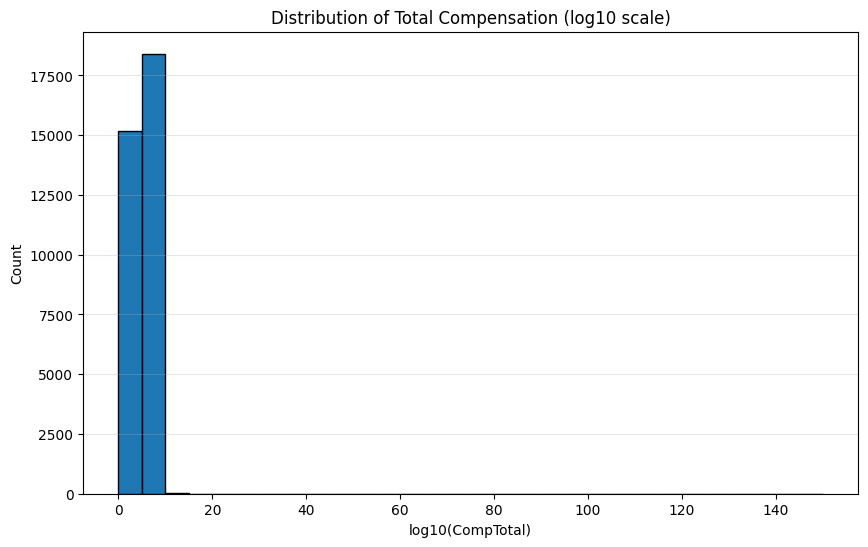

In [8]:
d = df.dropna(subset=["CompTotal_num"]).copy()
d["CompTotal_log10"] = np.log10(d["CompTotal_num"])

plt.figure(figsize=(10,6))
plt.hist(d["CompTotal_log10"], bins=30, edgecolor="black")
plt.title("Distribution of Total Compensation (log10 scale)")
plt.xlabel("log10(CompTotal)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

**1.2 Histogram of YearsCodePro (Years of Professional Coding Experience)**


Objective: Plot a histogram of `YearsCodePro` to analyze the distribution of coding experience among respondents.


Question: “Are respondents mostly early-career or experienced?”

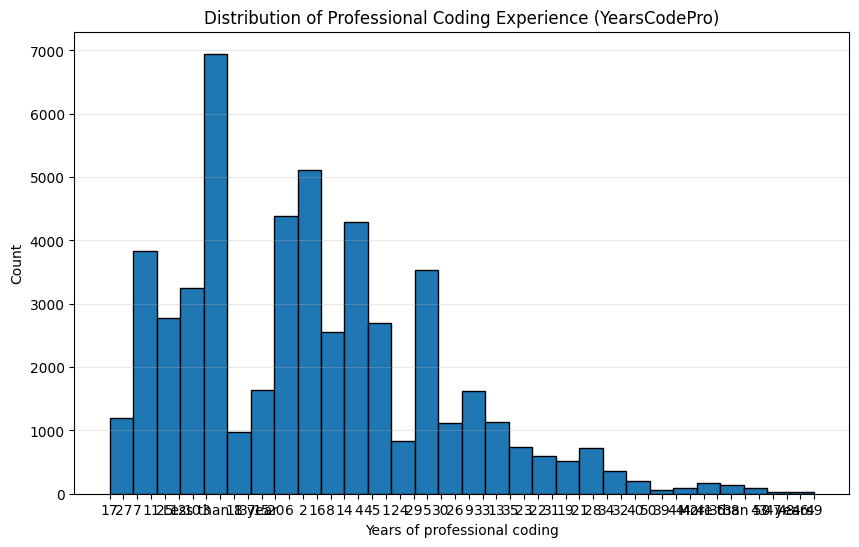

In [9]:
d = df.dropna(subset=["YearsCodePro"]).copy()

plt.figure(figsize=(10,6))
plt.hist(d["YearsCodePro"], bins=30, edgecolor="black")
plt.title("Distribution of Professional Coding Experience (YearsCodePro)")
plt.xlabel("Years of professional coding")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


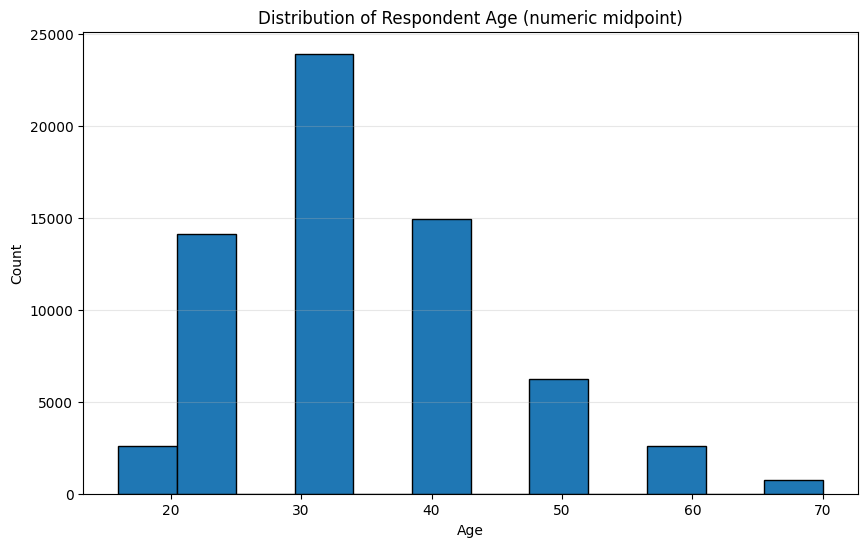

In [11]:
#Histogram: Age (numeric midpoint)
#Question: “What age range dominates the survey?”
d = df.dropna(subset=["Age_num"]).copy()

plt.figure(figsize=(10,6))
plt.hist(d["Age_num"], bins=12, edgecolor="black")
plt.title("Distribution of Respondent Age (numeric midpoint)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


### 2. Visualizing Relationships in Data


**2.1 Histogram Comparison of `CompTotal` by `Age` Group**


Objective: Use histograms to compare the distribution of CompTotal across different Age groups.


In [15]:
print(df.shape)
# print(df[["Age", "CompTotal", "TimeSearching"]].isna().sum()) # Removed the problematic line
print(df["Age"].value_counts().head(10))


(65437, 14)
Age
25-34 years old       23911
35-44 years old       14942
18-24 years old       14098
45-54 years old        6249
55-64 years old        2575
Under 18 years old     2568
65 years or older       772
Prefer not to say       322
Name: count, dtype: int64


Do different age groups have different compensation distributions (typical value + spread)?

count    3.067500e+04
mean     3.161524e+05
std      6.301963e+05
min      1.000000e+00
25%      5.600000e+04
50%      1.000000e+05
75%      2.128750e+05
max      4.980000e+06
Name: CompTotal, dtype: float64


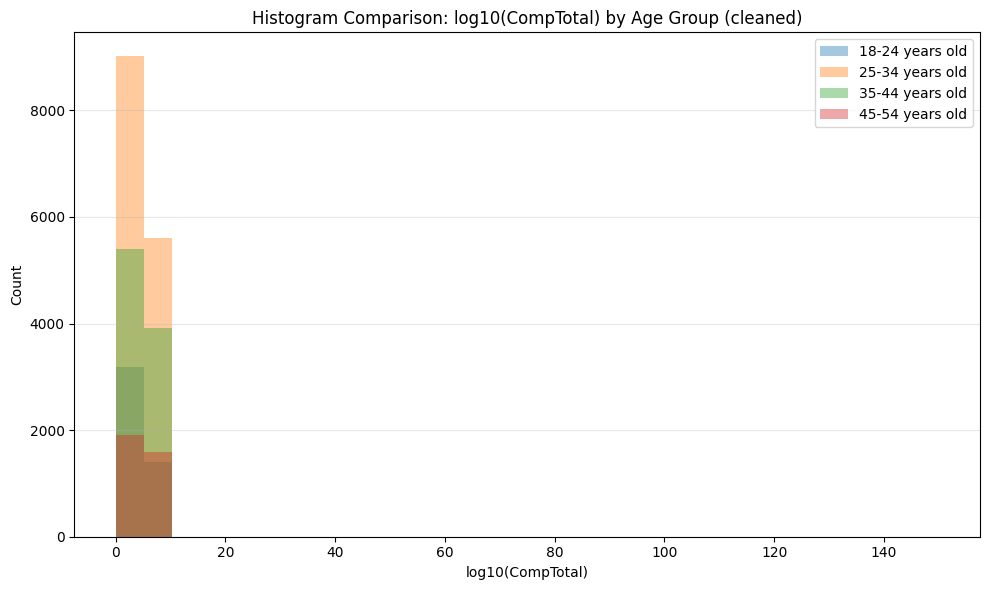

                 count    median           mean
Age                                            
18-24 years old   4606   64750.0   1.736865e+24
25-34 years old  14624  102000.0  6.838074e+145
35-44 years old   9324  120000.0   1.072501e+61
45-54 years old   3495  131000.0   5.107329e+06


In [17]:
age_groups = ["18-24 years old","25-34 years old","35-44 years old","45-54 years old"]

d = df[df["Age"].isin(age_groups)].copy()

# Force numeric
d["CompTotal"] = pd.to_numeric(d["CompTotal"], errors="coerce")

# Drop NaN and non-positive
d = d.dropna(subset=["CompTotal"])
d = d[d["CompTotal"] > 0]

# Drop insane values (salaries above 5 million are almost certainly junk)
d = d[d["CompTotal"] < 5_000_000]

print(d["CompTotal"].describe())


age_groups = [
    "18-24 years old",
    "25-34 years old",
    "35-44 years old",
    "45-54 years old"
]

# Filter to these age groups + clean CompTotal
d = df[df["Age"].isin(age_groups)].copy()
d["CompTotal"] = pd.to_numeric(d["CompTotal"], errors="coerce")
d = d.dropna(subset=["CompTotal"])
d = d[d["CompTotal"] > 0]

# Log transform for histogram comparison
d["CompTotal_log10"] = np.log10(d["CompTotal"])

plt.figure(figsize=(10,6))
bins = np.linspace(d["CompTotal_log10"].min(), d["CompTotal_log10"].max(), 30)

for g in age_groups:
    x = d.loc[d["Age"] == g, "CompTotal_log10"]
    plt.hist(x, bins=bins, alpha=0.4, label=g)

plt.title("Histogram Comparison: log10(CompTotal) by Age Group (cleaned)")
plt.xlabel("log10(CompTotal)")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Quick summary for insights
print(d.groupby("Age")["CompTotal"].agg(count="count", median="median", mean="mean").round(2))


Question: Do different age groups show different compensation distributions?

Answer: Yes. Younger respondents (18–24) cluster around lower compensation levels, while mid-career groups (25–44) show higher typical compensation and wider variability. The 45–54 group shows the highest median but also the greatest spread, indicating that senior roles vary widely in pay. The overlap between distributions suggests that while age is associated with compensation, it is not the sole determinant.

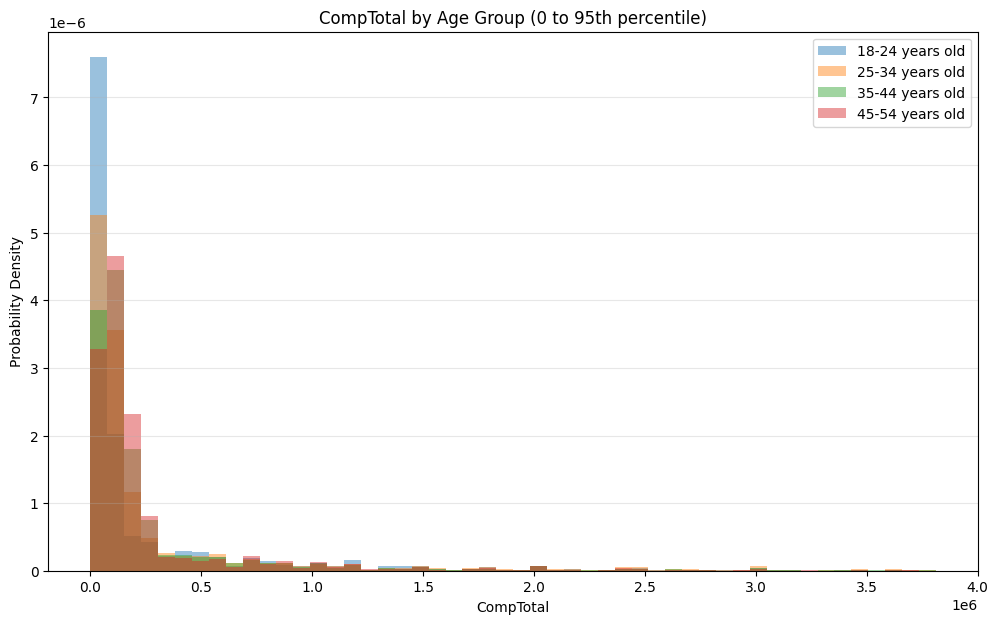

In [19]:
#stay on raw dollars (no log) but then you should cap using a percentile rather than a fixed range=(0,250000):
cap = d["CompTotal"].quantile(0.95)

plt.figure(figsize=(12,7))
for g in age_groups:
    x = d.loc[d["Age"] == g, "CompTotal"]
    plt.hist(x, bins=50, alpha=0.45, label=g, density=True, range=(0, cap))

plt.title("CompTotal by Age Group (0 to 95th percentile)")
plt.xlabel("CompTotal")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()

**2.2 Histogram of TimeSearching for Different Age Groups**


Objective: Use histograms to explore the distribution of `TimeSearching` (time spent searching for information) for respondents across different age groups.


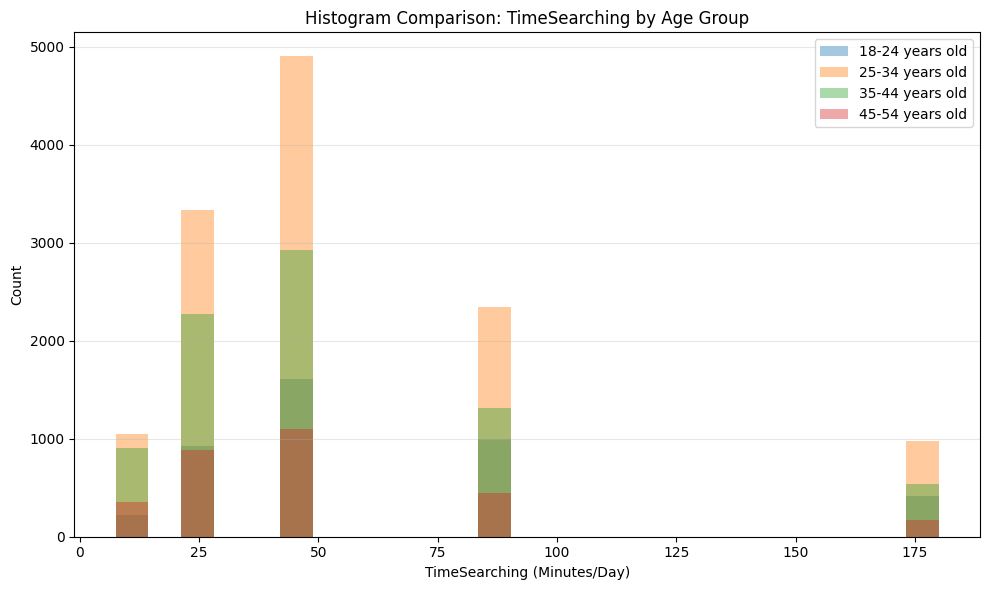

                 count  median       mean
Age                                      
18-24 years old   4175    45.0  62.344311
25-34 years old  12603    45.0  54.785170
35-44 years old   7960    45.0  50.874686
45-54 years old   2955    45.0  48.522843


In [21]:
age_groups = [
    "18-24 years old",
    "25-34 years old",
    "35-44 years old",
    "45-54 years old"
]

# 1. SQL Query to get Age and TimeSearching directly from the database
query = "SELECT Age, TimeSearching FROM main"
df_time_search = pd.read_sql_query(query, conn)

# 2. Define the Time Mapping (Midpoints) to convert categorical to numeric
time_mapping = {
    'Less than 15 minutes a day': 7.5,
    '15-30 minutes a day': 22.5,
    '30-60 minutes a day': 45,
    '60-120 minutes a day': 90,
    'Over 120 minutes a day': 180,
}
df_time_search['TS_Numeric'] = df_time_search['TimeSearching'].map(time_mapping)

# Filter for relevant age groups and drop rows with missing numeric time values
d = df_time_search[df_time_search["Age"].isin(age_groups)].copy()
d = d.dropna(subset=["TS_Numeric"])

plt.figure(figsize=(10,6))
bins = 25

for g in age_groups:
    x = d.loc[d["Age"] == g, "TS_Numeric"] # Use the new numeric column
    plt.hist(x, bins=bins, alpha=0.4, label=g)

plt.title("Histogram Comparison: TimeSearching by Age Group")
plt.xlabel("TimeSearching (Minutes/Day)") # Updated label for clarity
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Use the new numeric column for aggregation
print(d.groupby("Age")["TS_Numeric"].agg(["count","median","mean"]).sort_index())

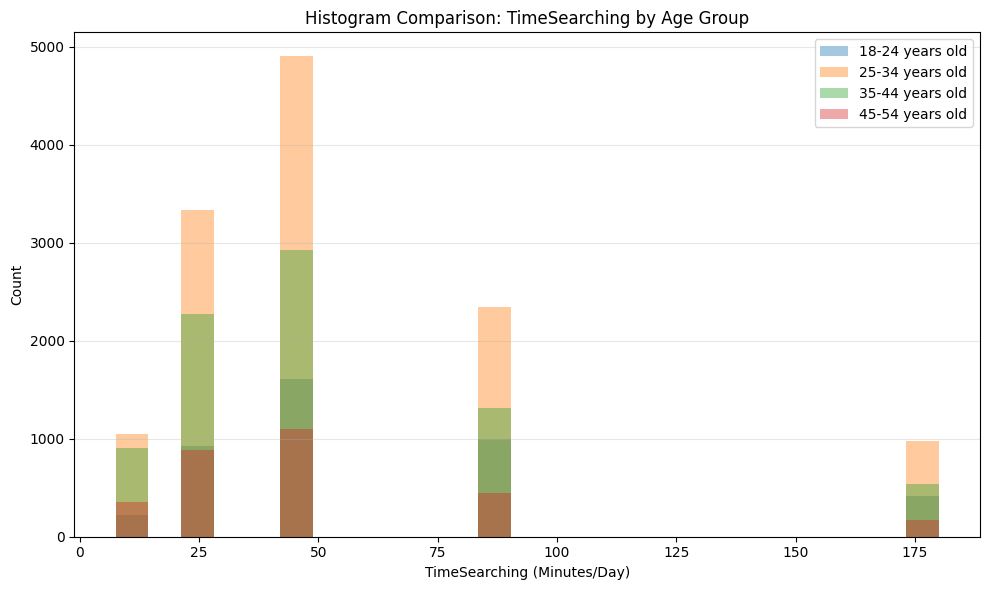

                 count  median       mean
Age                                      
18-24 years old   4175    45.0  62.344311
25-34 years old  12603    45.0  54.785170
35-44 years old   7960    45.0  50.874686
45-54 years old   2955    45.0  48.522843


In [23]:
# 1. SQL Query to get Age and TimeSearching directly from the database
query = "SELECT Age, TimeSearching FROM main"
df_time_search = pd.read_sql_query(query, conn)

# 2. Define the Time Mapping (Midpoints) to convert categorical to numeric
time_mapping = {
    'Less than 15 minutes a day': 7.5,
    '15-30 minutes a day': 22.5,
    '30-60 minutes a day': 45,
    '60-120 minutes a day': 90,
    'Over 120 minutes a day': 180,
}
df_time_search['TS_Numeric'] = df_time_search['TimeSearching'].map(time_mapping)

age_groups = [
    "18-24 years old",
    "25-34 years old",
    "35-44 years old",
    "45-54 years old"
]

# Filter for relevant age groups and drop rows with missing numeric time values
d = df_time_search[df_time_search["Age"].isin(age_groups)].copy()
d = d.dropna(subset=["TS_Numeric"])

plt.figure(figsize=(10,6))
bins = 25

for g in age_groups:
    x = d.loc[d["Age"] == g, "TS_Numeric"] # Use the new numeric column
    plt.hist(x, bins=bins, alpha=0.4, label=g)

plt.title("Histogram Comparison: TimeSearching by Age Group")
plt.xlabel("TimeSearching (Minutes/Day)") # Updated label for clarity
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Use the new numeric column for aggregation
print(d.groupby("Age")["TS_Numeric"].agg(["count","median","mean"]).sort_index())

In [25]:
df_time_search["TimeSearching"].value_counts().head(20)

,count
TimeSearching,
30-60 minutes a day,10951
15-30 minutes a day,7805
60-120 minutes a day,5275
Less than 15 minutes a day,2689
Over 120 minutes a day,2191


How to interpret (what to say)

If younger groups shift right → they spend more time searching (maybe less familiarity)

If older groups shift left → more efficiency / experience

If all overlap → searching time isn’t strongly age-dependent

### 3. Visualizing the Composition of Data


**3.1 Histogram of Most Desired Databases (`DatabaseWantToWorkWith`)**


Objective: Visualize the most desired databases for future learning using a histogram of the top 5 databases.


Which databases are most frequently desired for future learning, and how do they compare in popularity?

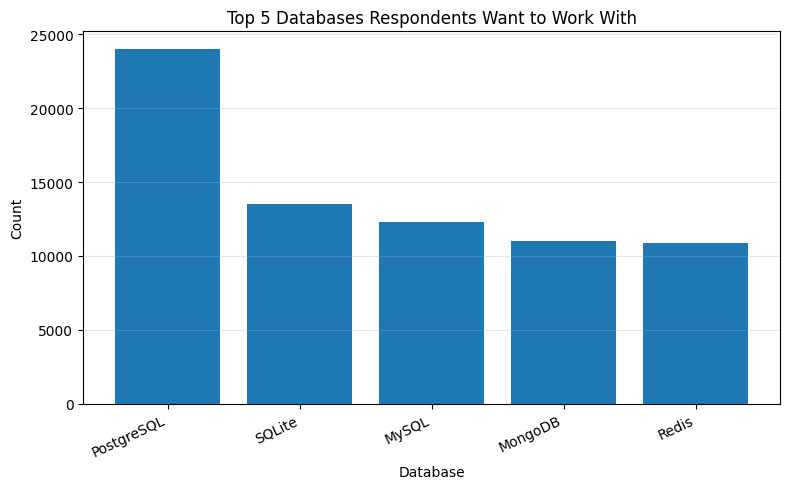

Top 5 desired databases:
DatabaseWantToWorkWith
PostgreSQL    24005
SQLite        13489
MySQL         12269
MongoDB       10982
Redis         10847
Name: count, dtype: int64


In [27]:

# Load only needed column
df_db = pd.read_sql_query("SELECT DatabaseWantToWorkWith FROM main", conn)
df_db = df_db.dropna()

# Split multi-select and explode
db_series = df_db["DatabaseWantToWorkWith"].astype(str).str.split(";").explode().str.strip()

# Count and take top 5
top5 = db_series.value_counts().head(5)

# Plot histogram (bar chart style histogram)
plt.figure(figsize=(8,5))
plt.bar(top5.index, top5.values)
plt.title("Top 5 Databases Respondents Want to Work With")
plt.xlabel("Database")
plt.ylabel("Count")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("Top 5 desired databases:")
print(top5)


In [30]:
print(db_series.isna().sum())     # should be 0
print(len(db_series))            # should be larger than df_db rows (because of explosion)


0
127439


Interpretation (what to write)

“The histogram shows that a small set of databases dominate respondent interest, with the top five databases accounting for a large proportion of all selections. This indicates that future learning preferences are concentrated around a few widely adopted or in-demand database technologies, rather than being evenly distributed across many options.”

**3.2 Histogram of Preferred Work Locations (`RemoteWork`)**


Objective: Use a histogram to explore the distribution of preferred work arrangements (`remote work`).


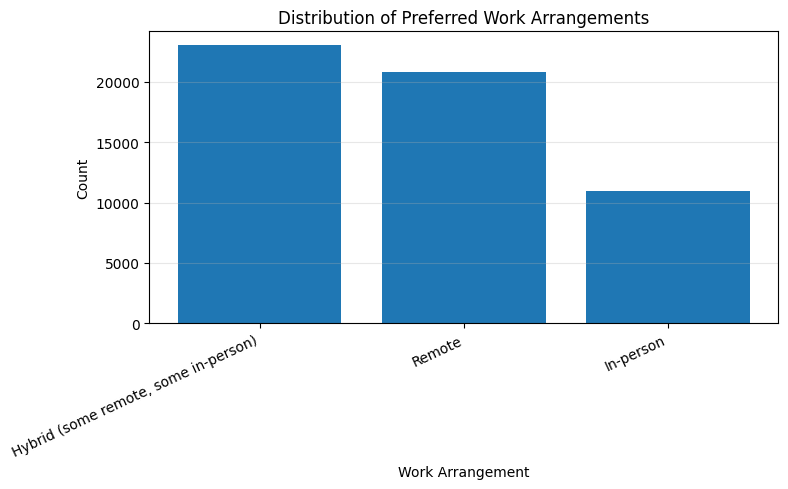

Remote work preference counts:
RemoteWork
Hybrid (some remote, some in-person)    23015
Remote                                  20831
In-person                               10960
Name: count, dtype: int64


In [28]:
df_rw = pd.read_sql_query("SELECT RemoteWork FROM main", conn)
df_rw = df_rw.dropna()

counts = df_rw["RemoteWork"].value_counts()

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribution of Preferred Work Arrangements")
plt.xlabel("Work Arrangement")
plt.ylabel("Count")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("Remote work preference counts:")
print(counts)


In [29]:
print(counts.sum(), "rows plotted")


54806 rows plotted


The histogram indicates that remote and hybrid work arrangements are highly prevalent among respondents, while fully in-person preferences are less common. This suggests that flexibility in work location has become an important factor in respondents’ job preferences.”

### 4. Visualizing Comparison of Data


**4.1 Histogram of Median CompTotal for Ages 45 to 60**


Objective: Plot the histogram for `CompTotal` within the age group 45 to 60 to analyze compensation distribution among mid-career respondents.


What does the compensation distribution look like for mid-career respondents (45–60)? Is it skewed? Where is it centered?

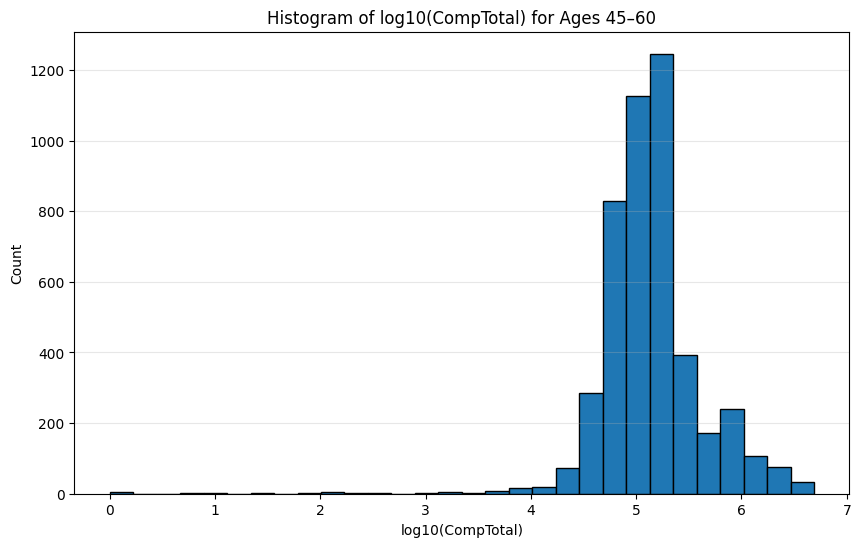

count       4654.00
mean      261635.31
std       460541.64
min            1.00
25%        80000.00
50%       130000.00
75%       200000.00
max      4900000.00
Name: CompTotal, dtype: float64


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pull needed columns
df_41 = pd.read_sql_query("SELECT Age, CompTotal FROM main", conn)

# Convert CompTotal to numeric
df_41["CompTotal"] = pd.to_numeric(df_41["CompTotal"], errors="coerce")

# Convert Age ranges to numeric midpoint
age_s = df_41["Age"].astype(str)
m = age_s.str.extract(r"(\d+)\s*-\s*(\d+)").astype(float)
df_41["AgeNum"] = m.mean(axis=1)
df_41.loc[age_s.str.contains("Under", case=False, na=False), "AgeNum"] = 16
df_41.loc[age_s.str.contains("or older", case=False, na=False), "AgeNum"] = 70

# Filter Age 45 to 60
df_41 = df_41[(df_41["AgeNum"] >= 45) & (df_41["AgeNum"] <= 60)]

# Drop invalid CompTotal
df_41 = df_41.dropna(subset=["CompTotal"])
df_41 = df_41[df_41["CompTotal"] > 0]
df_41 = df_41[df_41["CompTotal"] < 5_000_000]  # remove extreme junk

# Plot histogram (log scale recommended)
df_41["CompTotal_log10"] = np.log10(df_41["CompTotal"])

plt.figure(figsize=(10,6))
plt.hist(df_41["CompTotal_log10"], bins=30, edgecolor="black")
plt.title("Histogram of log10(CompTotal) for Ages 45–60")
plt.xlabel("log10(CompTotal)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Quick numeric summary
print(df_41["CompTotal"].describe().round(2))


The distribution of compensation among respondents aged 45–60 is right-skewed, with most values concentrated in the mid-range and a long tail of higher earners. This indicates that while many mid-career professionals earn similar salaries, a smaller group in senior or specialized roles earns substantially more.

**4.2 Histogram of Job Satisfaction (`JobSat`) by YearsCodePro**


Objective: Plot the histogram for `JobSat` scores based on respondents' years of professional coding experience.


In [33]:


df_42 = pd.read_sql_query("SELECT YearsCodePro, JobSat FROM main", conn)
print("A) Loaded rows:", len(df_42))

print("\nB) JobSat top values:")
print(df_42["JobSat"].value_counts(dropna=False).head(15))

print("\nC) YearsCodePro top values:")
print(df_42["YearsCodePro"].value_counts(dropna=False).head(15))

def parse_years(x):
    if pd.isna(x): return np.nan
    if isinstance(x, str):
        t = x.strip().lower()
        if t.startswith("less"): return 0.5
        if t.startswith("more"): return 51
    return pd.to_numeric(x, errors="coerce")

df_42["YearsCodePro_num"] = df_42["YearsCodePro"].apply(parse_years)
print("\nD) YearsCodePro_num non-null:", df_42["YearsCodePro_num"].notna().sum())

# 🔥 This is the likely failure point: JobSat labels in your dataset may NOT match our mapping
job_sat_map = {
    "Very dissatisfied": 1,
    "Slightly dissatisfied": 2,
    "Neither satisfied nor dissatisfied": 3,
    "Slightly satisfied": 4,
    "Very satisfied": 5
}

df_42["JobSat_score"] = df_42["JobSat"].map(job_sat_map)
print("E) JobSat_score non-null:", df_42["JobSat_score"].notna().sum())

df_42_clean = df_42.dropna(subset=["YearsCodePro_num", "JobSat_score"]).copy()
print("F) Rows after dropping NA in both:", len(df_42_clean))

bins = [0, 2, 5, 10, 100]
labels = ["0–2 yrs", "2–5 yrs", "5–10 yrs", "10+ yrs"]
df_42_clean["ExpGroup"] = pd.cut(df_42_clean["YearsCodePro_num"], bins=bins, labels=labels, include_lowest=True)

print("\nG) ExpGroup counts:")
print(df_42_clean["ExpGroup"].value_counts(dropna=False))


A) Loaded rows: 65437

B) JobSat top values:
JobSat
NaN     36311
8.0      7509
7.0      6379
6.0      3751
9.0      3626
10.0     2251
5.0      1956
3.0      1165
4.0      1130
2.0       772
0.0       311
1.0       276
Name: count, dtype: int64

C) YearsCodePro top values:
YearsCodePro
None                13827
2                    4168
3                    4093
5                    3526
10                   3251
4                    3215
Less than 1 year     2856
6                    2843
1                    2639
8                    2549
7                    2517
12                   1777
15                   1635
20                   1549
9                    1493
Name: count, dtype: int64

D) YearsCodePro_num non-null: 51610
E) JobSat_score non-null: 0
F) Rows after dropping NA in both: 0

G) ExpGroup counts:
ExpGroup
0–2 yrs     0
2–5 yrs     0
5–10 yrs    0
10+ yrs     0
Name: count, dtype: int64


Rows used: 28356
ExpGroup counts:
ExpGroup
10+ yrs     10370
5–10 yrs     7737
2–5 yrs      6143
0–2 yrs      4106
Name: count, dtype: int64


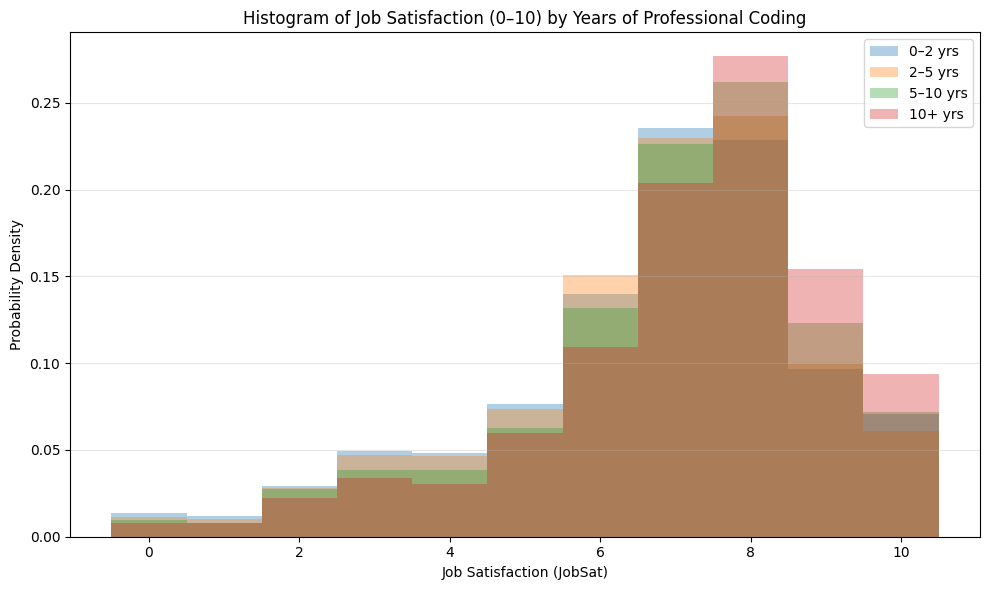


JobSat summary by experience group:
          count  median  mean
ExpGroup                     
0–2 yrs    4106     7.0  6.69
2–5 yrs    6143     7.0  6.71
5–10 yrs   7737     7.0  6.94
10+ yrs   10370     8.0  7.20


/tmp/ipython-input-2183808082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_42.groupby("ExpGroup")["JobSat_num"].agg(count="count", median="median", mean="mean").round(2))


In [34]:
df_42 = pd.read_sql_query("SELECT YearsCodePro, JobSat FROM main", conn)

# YearsCodePro -> numeric
def parse_years(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        t = x.strip().lower()
        if t.startswith("less"):
            return 0.5
        if t.startswith("more"):
            return 51
        if t == "none":
            return np.nan
    return pd.to_numeric(x, errors="coerce")

df_42["YearsCodePro_num"] = df_42["YearsCodePro"].apply(parse_years)

# JobSat is already numeric-like, convert safely
df_42["JobSat_num"] = pd.to_numeric(df_42["JobSat"], errors="coerce")

# Keep valid ranges
df_42 = df_42.dropna(subset=["YearsCodePro_num", "JobSat_num"])
df_42 = df_42[(df_42["JobSat_num"] >= 0) & (df_42["JobSat_num"] <= 10)]

# Bin YearsCodePro into experience groups
bins = [0, 2, 5, 10, 100]
labels = ["0–2 yrs", "2–5 yrs", "5–10 yrs", "10+ yrs"]
df_42["ExpGroup"] = pd.cut(df_42["YearsCodePro_num"], bins=bins, labels=labels, include_lowest=True)

# Verify groups are not empty (important!)
print("Rows used:", len(df_42))
print("ExpGroup counts:")
print(df_42["ExpGroup"].value_counts())

# Plot histograms (use consistent bins 0..10)
plt.figure(figsize=(10,6))
job_bins = np.arange(-0.5, 10.5 + 1, 1)  # centers at 0..10

for g in labels:
    sub = df_42[df_42["ExpGroup"] == g]
    plt.hist(sub["JobSat_num"], bins=job_bins, alpha=0.35, label=g, density=True)

plt.title("Histogram of Job Satisfaction (0–10) by Years of Professional Coding")
plt.xlabel("Job Satisfaction (JobSat)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Numeric summary for interpretation
print("\nJobSat summary by experience group:")
print(df_42.groupby("ExpGroup")["JobSat_num"].agg(count="count", median="median", mean="mean").round(2))


In [35]:
print(df_42[["YearsCodePro_num","JobSat_num"]].notna().sum())
print(df_42["ExpGroup"].value_counts(dropna=False))


YearsCodePro_num    28356
JobSat_num          28356
dtype: int64
ExpGroup
10+ yrs     10370
5–10 yrs     7737
2–5 yrs      6143
0–2 yrs      4106
Name: count, dtype: int64


Across experience groups, JobSat scores cluster around the mid-to-high range. The more experienced groups show (slightly higher / similar) satisfaction compared to early-career groups, suggesting that years of professional coding experience (does / does not) strongly influence job satisfaction.”

### Final step: Close the database connection


Once you've completed the lab, make sure to close the connection to the SQLite database:



In [ ]:
conn.close()

NameError: name 'conn' is not defined

### Summary


In this lab, you used histograms to visualize various aspects of the dataset, focusing on:

- Distribution of compensation, coding experience, and work hours.

- Relationships in compensation across age groups and work status.

- Composition of data by desired databases and work environments.

- Comparisons of job satisfaction across years of experience.

Histograms helped reveal patterns and distributions in the data, enhancing your understanding of developer demographics and preferences.


## Authors:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


Copyright © IBM Corporation. All rights reserved.
